In [1]:
import pandas as pd
import datetime as dt
import win32com.client
import pywintypes
from dateutil.relativedelta import relativedelta

## Get data
https://pythoninoffice.com/get-outlook-calendar-meeting-data-using-python/

In [2]:
def get_calendar(begin,end):
    outlook = win32com.client.Dispatch('Outlook.Application').GetNamespace('MAPI')
    restriction = "[Start] >= '" + begin.strftime('%Y-%m-%d') + "' AND [END] <= '" + end.strftime('%Y-%m-%d') + "'"
    
    # For the normal calendar
    calendar = outlook.getDefaultFolder(9).Items
    calendar.IncludeRecurrences = True
    calendar.Sort('[Start]')
    calendar = calendar.Restrict(restriction)
    
    # For the time management calendar
    calendar_tm = outlook.getDefaultFolder(9).Folders['Time Management'].Items
    calendar_tm.IncludeRecurrences = True
    calendar_tm.Sort('[Start]')
    calendar_tm = calendar_tm.Restrict(restriction)
    
    # For the garmin connect calendar
    calendar_gc = outlook.Folders['ale_780_simo@hotmail.com'].Folders.Item(9).Folders['Garmin Connect'].Items
    calendar_gc.IncludeRecurrences = True
    calendar_gc.Sort('[Start]')
    calendar_gc = calendar_gc.Restrict(restriction)
    return calendar, calendar_tm, calendar_gc

### Appointment object docs
https://docs.microsoft.com/en-us/office/vba/api/outlook.appointmentitem

In [3]:
def get_appointments(calendar):
    appointments = [app for app in calendar] 
    
    cal_start = [app.start.strftime('%Y-%m-%d %H:%M:%S') for app in appointments]
    cal_end = [pd.to_datetime(app.end.strftime('%Y-%m-%d %H:%M:%S'), format='%Y%m%d', errors='ignore') for app in appointments]
    cal_duration = [app.duration for app in appointments]
    cal_categories = [app.categories for app in appointments]
    cal_BusyStatus = [app.BusyStatus for app in appointments]
    cal_AllDayEvent = [app.AllDayEvent for app in appointments]
    cal_subject = [app.subject for app in appointments]
    cal_body = [app.body for app in appointments]
    cal_organizer = [app.organizer for app in appointments]

    df = pd.DataFrame({'start': cal_start,
                       'end': cal_end,
                       'duration': cal_duration,
                       'categories': cal_categories,
                       'BusyStatus': cal_BusyStatus,
                       'AllDayEvent': cal_AllDayEvent,
                       'subject': cal_subject,
                       'body': cal_body,
                       'Organizer':cal_organizer,
                      })
    return df

def make_cpd(appointments):
    appointments['Date'] = appointments['start']
    appointments['Hours'] = (appointments['end'] - appointments['start']).dt.seconds/3600
    appointments.rename(columns={'subject':'Meeting Description'}, inplace = True)
    appointments.drop(['start','end'], axis = 1, inplace = True)
    summary = appointments.groupby('Meeting Description')['Hours'].sum()
    return summary

### Get calendars between selected dates

In [13]:
begin = dt.datetime(2021, 1, 3) #(yyyy, dd, mm)
end = dt.datetime(2021, 8, 15) #(yyyy, mm, dd)

cal, cal_tm, cal_gc = get_calendar(begin, end)

In [14]:
df_tm = get_appointments(cal_tm) #Time Management Calendar
df_cal = get_appointments(cal) #KI Outlook Calendar
df_gc = get_appointments(cal_gc) #Garmin Connect Calendar
df = pd.concat([df_cal, df_tm, df_gc])

In [15]:
df['Date'] = pd.to_datetime(df['start'], dayfirst=True)
df = df.set_index('Date')
df = df.sort_index()
df = df[df['BusyStatus']==2] #Take only events marked as busy
df = df[df['AllDayEvent']==False] #Don't take all day events

In [16]:
# df[df['categories']=='Simon']
df.tail()

,start,end,duration,categories,BusyStatus,AllDayEvent,subject,body,Organizer
Date,,,,,,,,,
2021-08-12 12:00:00,2021-08-12 12:00:00,2021-08-12 12:30:00,30,Other - Not Work,2,False,Lunch,,"Simo Vesperinas, Alejandro"
2021-08-12 13:00:00,2021-08-12 13:00:00,2021-08-12 14:00:00,60,Reporting,2,False,Alejandro's Weekly Meeting,"Hello all,\r\n\r\n \r\n\r\nI would like to inv...","Simo Vesperinas, Alejandro"
2021-08-13 10:00:00,2021-08-13 10:00:00,2021-08-13 12:00:00,120,Other - Work,2,False,Bi-Weekly Technical Meeting,Teoretikus mozeme zacat hned po rannej porade....,"Baculikova, Ivana"
2021-08-13 12:00:00,2021-08-13 12:00:00,2021-08-13 12:30:00,30,Other - Not Work,2,False,Lunch,,"Simo Vesperinas, Alejandro"
2021-08-13 12:30:00,2021-08-13 12:30:00,2021-08-13 12:40:00,10,Other - Not Work,2,False,Order Next Week Food,,"Simo Vesperinas, Alejandro"


In [17]:
df.to_csv('Calendar_Analytics.csv')

In [46]:
df.dtypes

start          object
end            object
duration        int64
categories     object
BusyStatus      int64
AllDayEvent      bool
subject        object
body           object
Organizer      object
dtype: object

# Analysis

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

### Visualize all dates

In [35]:
d  = df.groupby(by='categories').sum().sort_values(by='duration', ascending=False)
d["cumpercentage"] = d["duration"].cumsum()/d["duration"].sum()*100
d.head()

,duration,BusyStatus,AllDayEvent,cumpercentage
categories,,,,
Defects Detection,14130,252,False,32.009605
Sport,4849,172,False,42.994359
Trainings,4170,126,False,52.440931
Tableau,3840,88,False,61.139932
Fire and Failure Prediction,3740,84,False,69.612396


In [36]:
projects = ['Defects Detection', 
            'Tableau', 
            'Reporting', 
            'Fire and Failure Prediction', 
            'Spinner Waste', 
            'Binder and Density Distribution',
            'Other - Work',
            'AI Team',
            'GMW Fiberizing']
d = d[d.index.get_level_values(0).isin(projects)]
d.head()

,duration,BusyStatus,AllDayEvent,cumpercentage
categories,,,,
Defects Detection,14130,252,False,32.009605
Tableau,3840,88,False,61.139932
Fire and Failure Prediction,3740,84,False,69.612396
Other - Work,3295,88,False,84.960243
Reporting,2040,54,False,95.494189


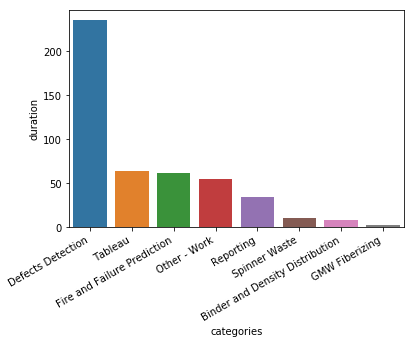

In [37]:
ax = sns.barplot(y = d['duration']/60,
                 x = d.index,
                 data=d)
plt.xticks(rotation=30, ha = 'right');

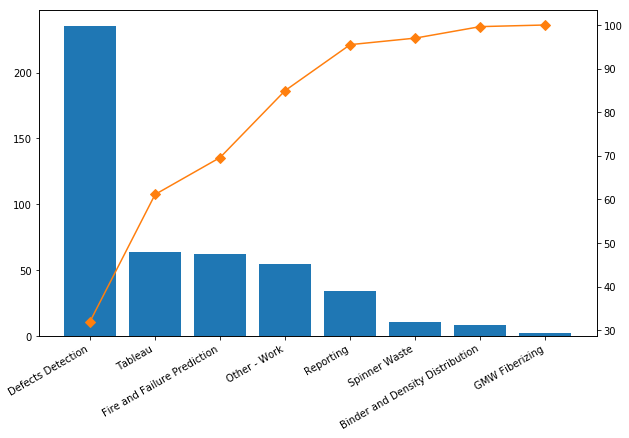

In [38]:
fig, ax = plt.subplots(figsize =(10, 6))

ax.bar(d.index, d['duration']/60, color="C0")
ax2 = ax.twinx()
ax2.plot(d.index, d["cumpercentage"], color="C1", marker="D", ms=7)

plt.setp( ax.xaxis.get_majorticklabels(), rotation=30, ha = 'right' );

#### Only garmin connect calendar

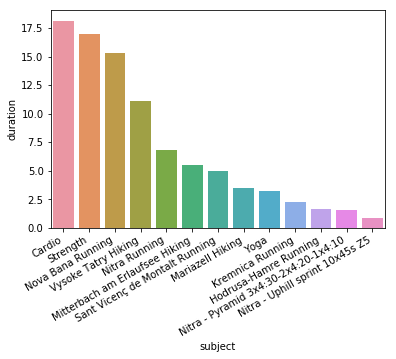

In [39]:
d  = df_gc.groupby(by='subject').sum().sort_values(by='duration', ascending=False)

ax = sns.barplot(y = d['duration']/60,
                 x = d.index,
                 data=d)
plt.xticks(rotation=30, ha = 'right');

### Groupby date

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Hours of recorded events per day')

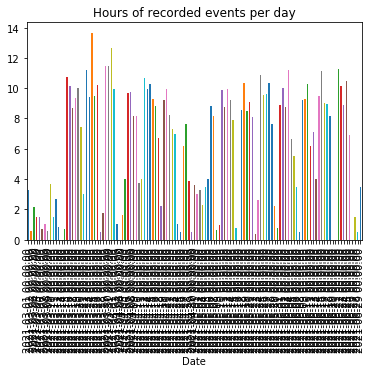

In [40]:
(df['duration'].groupby(pd.TimeGrouper('D')).sum()/60).plot.bar()
plt.title('Hours of recorded events per day')

In [17]:
projects = ['Defects Detection', 
            'Tableau', 
            'Reporting', 
            'Fire and Failure Prediction', 
            'Spinner Waste', 
            'Binder and Density Distribution',
            'Other - Work',
            'AI Team',
            'Trainings',
            'GMW Fiberizing']
d = df[df['categories'].isin(projects)]
d.head()

,start,end,duration,categories,BusyStatus,AllDayEvent,subject,body,Organizer
Date,,,,,,,,,
2021-03-01 09:30:00,2021-03-01 09:30:00,2021-03-01 10:30:00,60,Spinner Waste,2,False,"Trough shape, spinner waste and BAE",\r\n,"Simo Vesperinas, Alejandro"
2021-03-01 13:00:00,2021-03-01 13:00:00,2021-03-01 13:30:00,30,GMW Fiberizing,2,False,Fiber Diameter Maninput,We have a small issue with the extb mantra con...,"Simo Vesperinas, Alejandro"
2021-03-01 14:00:00,2021-03-01 14:00:00,2021-03-01 15:00:00,60,Binder and Density Distribution,2,False,BAE + binder distribution,\r\n,"Bais, Maros"
2021-03-03 11:00:00,2021-03-03 11:00:00,2021-03-03 11:30:00,30,Spinner Waste,2,False,Curved Trough NB,I propose Wednesday at 11:00 to have this meet...,"Simo Vesperinas, Alejandro"
2021-03-03 17:30:00,2021-03-03 17:30:00,2021-03-03 18:30:00,60,Trainings,2,False,Enabling Cloud Connectivity for Predictive Ana...,Thank you for registering for our live webinar...,


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Hours of work per day')

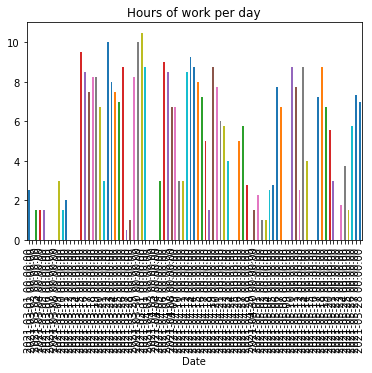

In [18]:
(d['duration'].groupby(pd.TimeGrouper('D')).sum()/60).plot.bar()
plt.title('Hours of work per day')

#### Group by categories and weeks

In [19]:
df_gr = df.reset_index().set_index(['categories', 'Date']).groupby(['categories', pd.Grouper(freq='7D', level=-1)]).sum()
df_gr.head()

duration  BusyStatus  \
categories                      Date                                        
                                2021-05-17 09:30:00        54           2   
Binder and Density Distribution 2021-03-01 09:30:00        90           4   
                                2021-04-12 09:30:00       150           4   
Crimping                        2021-03-22 09:30:00       360          10   
                                2021-05-10 09:30:00       540          10   

                                                     AllDayEvent  
categories                      Date                              
                                2021-05-17 09:30:00        False  
Binder and Density Distribution 2021-03-01 09:30:00        False  
                                2021-04-12 09:30:00        False  
Crimping                        2021-03-22 09:30:00        False  
                                2021-05-10 09:30:00        False

#### Select dates

In [20]:
start = dt.datetime(year=2021, month = 3, day =8)
end = dt.datetime(year=2021, month = 4, day =4)
d = df_gr[(df_gr.index.get_level_values('Date')>=start) & (df_gr.index.get_level_values('Date')<=end)]

In [21]:
projects = ['Defects Detection', 
            'Tableau', 
            'Reporting', 
            'Fire and Failure Prediction', 
            'Spinner Waste', 
            'Binder and Density Distribution',
            'Other - Work',
            'AI Team',
            'GMW Fiberizing']
d = d[d.index.get_level_values(0).isin(projects)]
d

duration  BusyStatus  \
categories                  Date                                        
Defects Detection           2021-03-08 09:30:00        90           4   
                            2021-03-15 09:30:00      1785          22   
                            2021-03-22 09:30:00      1395          28   
                            2021-03-29 09:30:00       915          14   
Fire and Failure Prediction 2021-03-15 09:30:00        90           4   
                            2021-03-22 09:30:00       180           4   
                            2021-03-29 09:30:00       525          10   
Other - Work                2021-03-08 09:30:00       120           2   
                            2021-03-15 09:30:00       300           6   
                            2021-03-22 09:30:00       540          14   
Reporting                   2021-03-08 09:30:00        60           2   
                            2021-03-15 09:30:00       630          10   
                            2021-03-22 09:30:00        60           2   
                            2021-03-29 09:30:00        90           4   
Spinner Waste               2021-03-08 09:30:00       120           2   
                            2021-03-15 09:30:00        30           2   
                            2021-03-22 09:30:00        15           2   
Tableau                     2021-03-08 09:30:00        60           2   
                            2021-03-15 09:30:00       300           8   
                            2021-03-22 09:30:00       420          12   
                            2021-03-29 09:30:00       450          10   

                                                 AllDayEvent  
categories                  Date                              
Defects Detection           2021-03-08 09:30:00        False  
                            2021-03-15 09:30:00        False  
                            2021-03-22 09:30:00        False  
                            2021-03-29 09:30:00        False  
Fire and Failure Prediction 2021-03-15 09:30:00        False  
                            2021-03-22 09:30:00        False  
                            2021-03-29 09:30:00        False  
Other - Work                2021-03-08 09:30:00        False  
                            2021-03-15 09:30:00        False  
                            2021-03-22 09:30:00        False  
Reporting                   2021-03-08 09:30:00        False  
                            2021-03-15 09:30:00        False  
                            2021-03-22 09:30:00        False  
                            2021-03-29 09:30:00        False  
Spinner Waste               2021-03-08 09:30:00        False  
                            2021-03-15 09:30:00        False  
                            2021-03-22 09:30:00        False  
Tableau                     2021-03-08 09:30:00        False  
                            2021-03-15 09:30:00        False  
                            2021-03-22 09:30:00        False  
                            2021-03-29 09:30:00        False

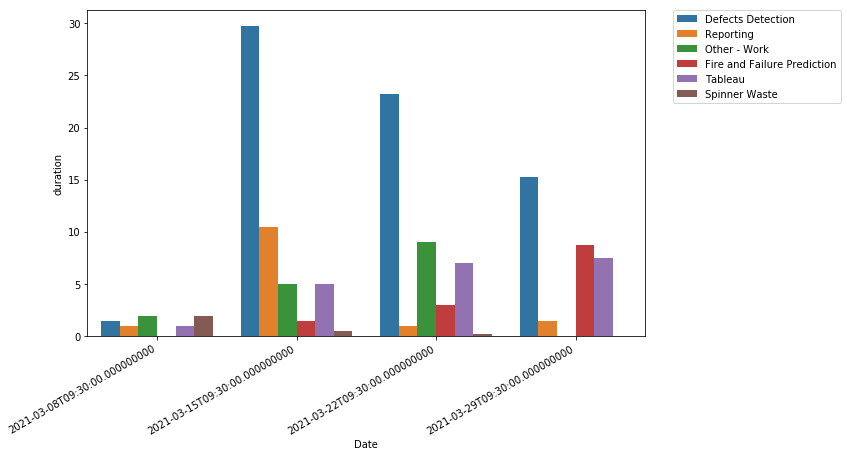

In [22]:
fig, ax = plt.subplots(figsize =(10, 6))

d = d.sort_values(by='duration', ascending=False)

ax = sns.barplot(y = d['duration']/60,
                 x = d.index.get_level_values(1),
                 hue = d.index.get_level_values(0),
                 data=d)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=30, ha = 'right');

In [23]:
d['duration'] = pd.to_timedelta(d['duration'], unit ='m')

In [24]:
d

duration  BusyStatus  \
categories                  Date                                              
Defects Detection           2021-03-15 09:30:00 1 days 05:45:00          22   
                            2021-03-22 09:30:00 0 days 23:15:00          28   
                            2021-03-29 09:30:00 0 days 15:15:00          14   
Reporting                   2021-03-15 09:30:00 0 days 10:30:00          10   
Other - Work                2021-03-22 09:30:00 0 days 09:00:00          14   
Fire and Failure Prediction 2021-03-29 09:30:00 0 days 08:45:00          10   
Tableau                     2021-03-29 09:30:00 0 days 07:30:00          10   
                            2021-03-22 09:30:00 0 days 07:00:00          12   
Other - Work                2021-03-15 09:30:00 0 days 05:00:00           6   
Tableau                     2021-03-15 09:30:00 0 days 05:00:00           8   
Fire and Failure Prediction 2021-03-22 09:30:00 0 days 03:00:00           4   
Spinner Waste               2021-03-08 09:30:00 0 days 02:00:00           2   
Other - Work                2021-03-08 09:30:00 0 days 02:00:00           2   
Defects Detection           2021-03-08 09:30:00 0 days 01:30:00           4   
Reporting                   2021-03-29 09:30:00 0 days 01:30:00           4   
Fire and Failure Prediction 2021-03-15 09:30:00 0 days 01:30:00           4   
Tableau                     2021-03-08 09:30:00 0 days 01:00:00           2   
Reporting                   2021-03-22 09:30:00 0 days 01:00:00           2   
                            2021-03-08 09:30:00 0 days 01:00:00           2   
Spinner Waste               2021-03-15 09:30:00 0 days 00:30:00           2   
                            2021-03-22 09:30:00 0 days 00:15:00           2   

                                                 AllDayEvent  
categories                  Date                              
Defects Detection           2021-03-15 09:30:00        False  
                            2021-03-22 09:30:00        False  
                            2021-03-29 09:30:00        False  
Reporting                   2021-03-15 09:30:00        False  
Other - Work                2021-03-22 09:30:00        False  
Fire and Failure Prediction 2021-03-29 09:30:00        False  
Tableau                     2021-03-29 09:30:00        False  
                            2021-03-22 09:30:00        False  
Other - Work                2021-03-15 09:30:00        False  
Tableau                     2021-03-15 09:30:00        False  
Fire and Failure Prediction 2021-03-22 09:30:00        False  
Spinner Waste               2021-03-08 09:30:00        False  
Other - Work                2021-03-08 09:30:00        False  
Defects Detection           2021-03-08 09:30:00        False  
Reporting                   2021-03-29 09:30:00        False  
Fire and Failure Prediction 2021-03-15 09:30:00        False  
Tableau                     2021-03-08 09:30:00        False  
Reporting                   2021-03-22 09:30:00        False  
                            2021-03-08 09:30:00        False  
Spinner Waste               2021-03-15 09:30:00        False  
                            2021-03-22 09:30:00        False

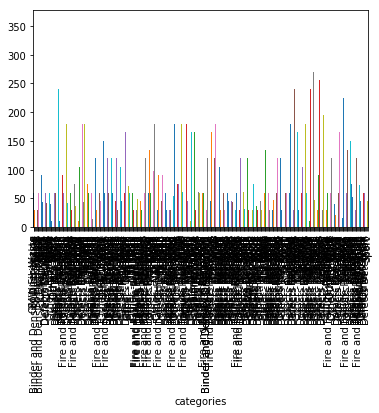

In [25]:
df.set_index('categories')['duration'].T.plot(kind='bar', stacked=True)

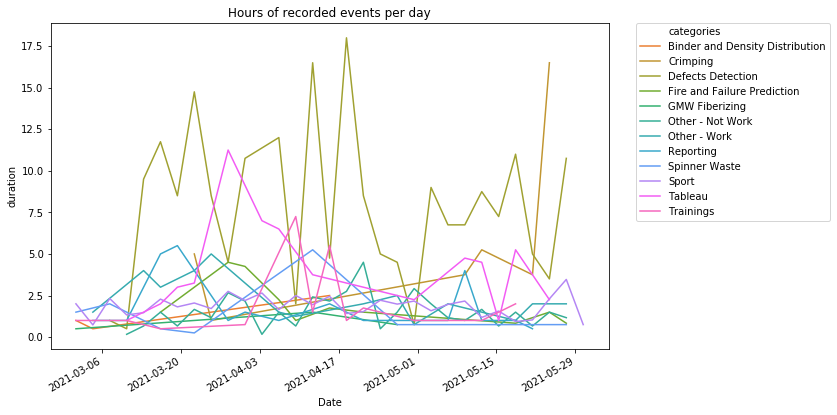

In [26]:
fig, ax = plt.subplots(figsize =(10, 6))

d = df.reset_index().set_index(['categories', 'Date']).groupby(['categories', pd.Grouper(freq='3D', level=-1)]).sum()

ax = sns.lineplot(y = d['duration']/60,
                 x = d.index.get_level_values(1),
                 hue = d.index.get_level_values(0),
                 data=d)

plt.title('Hours of recorded events per day')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=30, ha = 'right');

# Dashboard